# Deconvolution of lattice light sheet data in Python


## Aim

The previous worksheet documented how to deskew lattice light sheet data and rotate it back to coverslip coordinates.

In addition to these steps one may want to perform deconvolution to restore some of the detail that is blurred by the PSF of the acquisition system. 

## Resources

A good overview of deconvolution algorithms can be found in Daniel Sage et al's paper [DeconvolutionLab2](http://bigwww.epfl.ch/deconvolution/deconvolutionlab2/). 
The paper is a companion to the Fiji plugin of the same name.

DeconvolutionLab2 is written in Java, but we need an implementation in Python. Given the vast amounts of data produced by a lattice lightsheet microscope a fast implementation is mandatory. For a fast implementation GPU support and a fast graphics card are essential. However, it would be nice if the code could also be run on normal CPUs. 
 
The [flowdec](https://github.com/hammerlab/flowdec) package by Eric Czech meets these requirements. `Flowdec` employs `tensorflow` for implementing the Richardson-Lucy (RL) deconvolution algorithm. `Tensorflow` supports various hardware backeneds, mainly CPU and Nvidia-based GPUs with CUDA (`tensorflow-gpu`). There are also some experimental versions optimized for AMD-based GPUs using ROCm. (add link)   

An added benefit provided by `flowdec` is that possibility to keep intermediate results by registering an observer function that gets called at each iteration step of the RL algorithm. 
(see example here https://github.com/hammerlab/flowdec/issues/9)

## Implementation

Given an input volume, one can simply run RL deconvolution in `flowdec` by supplying an image volume, a point spread function (PSF), and the desired number of iterations.

### PSF acquisition and processing

Before runnning the RL iterations we need to preprocess the volume and the PSFs. Both DeconvolutionLab2 and Flowdec seem to expect the PSF to be supplied as a volume of the same size as the input image, with the PSF centred in the volume. Here, we obtain the PSF from a Z-stack of a single fluorescent bead. For the PSF acquisition the lightsheet was moved through the sample volume using a galvo scanner (as opposed to scanning the sample through the light sheet using the sample stage). Note that in contrast to stage scanning, a volume acquired with the galvo scanner is not skewed, because the sheet is scanned perpendicular to the optical axis of the acquisition objective. 

1. **PSF resampling**
For deconvolution, both PSF and sample volume must have a matching sampling interval in X, Y and Z. 
If they do not match, either the acquisition volume or the PSF must be resmapled. In this implementation, we resample the PSF.
1. **Background subtraction** we estimate and subtract the background intensity in the PSF volume and the sample volume. 
1. **Padding and centering** we locate the maximum of the PSF and centre it in the array. The arraay with the PSF is then padded to match the dimensions of the sample volume.


## PSF Resampling options

We consider two different approaches for resampling the PSF.


### Option 1: Deconvolution of deskewed light sheet stacks

In this case, deconvolution is performed on the volume after it has been deskewed (but before it is rotated to coverslip coordinates. In this case, PSF resampling is a simple matter of rescaling/interpolating along Z.


### Option 2: Deconvolution of raw light sheet stacks

The deconvolution operation can be performed on the raw light sheet image data. In this case, scaling the galvo-scanned PSF is not sufficient. It must also be skewed to match the stage-scanned sample volume. The benefit of this approach is processing speed, as only the raw voxels are processed during the deconvolution (for option one, fill pixels introduced during the deskewing are also processed). 

In [4]:
from lls_dd.transform_helpers import *
from lls_dd.transforms import *
import numpy as np
import tifffile
## Depending on whether you want to use ndimage or gputools, uncomment one of the following
## two lines
#from scipy.ndimage import affine_transform
from lls_dd.gputools_wrapper import affine_transform_gputools as affine_transform
from numpy.linalg import inv
from skimage.feature import peak_local_max
from skimage.filters import gaussian
import tensorflow as tf
from flowdec import restoration as tfd_restoration
from flowdec import data as fd_data
import matplotlib.pyplot as plt

### Read and plot PSF

the PSF file can be downloaded here:
https://www.dropbox.com/s/39ljascy4vkp0tk/488_PSF_galvo_CamA_ch0_stack0000_488nm_0000000msec_0016836088msecAbs.tif?dl=0

Adjust the path in the cell below, so it points to the download.

c:\users\volker\anaconda3\envs\spimenv\lib\site-packages\tifffile\tifffile.py:4267: UserWarning: tag 32781: coercing invalid ASCII to bytes
  warnings.warn('tag %i: coercing invalid ASCII to bytes' % code)


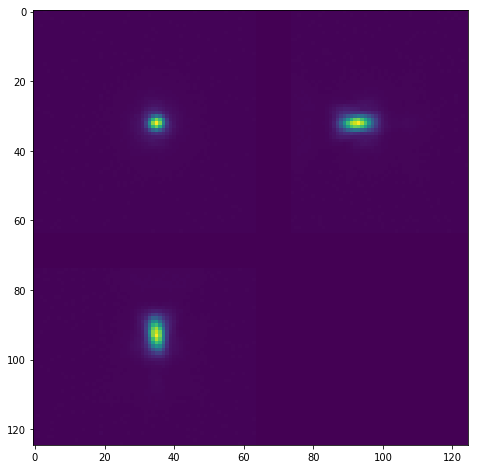

In [7]:
# Suppress annoying warnings due to malformed tiffs from Labview
import logging
logging.getLogger("tifffile").setLevel(logging.ERROR)

psf = tifffile.imread("C:/Users/Volker/Downloads/488_PSF_galvo_CamA_ch0_stack0000_488nm_0000000msec_0016836088msecAbs.tif")

plt.rcParams['figure.figsize'] = (16,8)
plot_all([get_projection_montage(psf)])

## Read the input volumes

* RAW input volume (same as in notebook 00) https://www.dropbox.com/s/34ei5jj0qgylf8q/drp1_dendra2_test_1_CamA_ch0_stack0000_488nm_0000000msec_0018218290msecAbs.tif?dl=0
* Deskewed volume: 


In [9]:
# dropbox link to dataset in previous notebook
vol_raw = tifffile.imread("c:/Users/Volker/Downloads/drp1_dendra2_test_1_CamA_ch0_stack0000_488nm_0000000msec_0018218290msecAbs.tif")
# Read the deskewed volume (saved as intermediate result in the preceding notebook)
#vol_deskewed = tifffile.imread("../d")

c:\users\volker\anaconda3\envs\spimenv\lib\site-packages\tifffile\tifffile.py:4267: UserWarning: tag 32781: coercing invalid ASCII to bytes
  warnings.warn('tag %i: coercing invalid ASCII to bytes' % code)


## Parameters

For this notebook we set the processing parameters as variables. In pratice you will want to extract most of these from the metadata/settings file.


In [10]:
# Volume acquisition parameters
xypixelsize = 0.1040
angle = 31.8
dz_stage = 0.299401
dz = np.sin(angle*np.pi/180.0)*dz_stage
dx = xypixelsize
deskewfactor = np.cos(angle*np.pi/180.0)*dz_stage/dx
dzdx_aspect = dz/dx

# PSF acquisition parameters
dz_galvo = 0.1
dz_ratio_galvo_stage = dz_galvo/dz

print("Sample acquisition parameter summary:")
print("=====================================")
print("dx, dy:", dx)
print("dz:", dz)
print("deskewfactor:", deskewfactor)
print("voxel aspect ratio z-voxel/xy-voxel:", dzdx_aspect)



print("PSF acquisition parameters:")
print("=====================================")
print("dz galvo:", dz_galvo)
print("dz galvo/dz", dz_ratio_galvo_stage)

Sample acquisition parameter summary:
dx, dy: 0.104
dz: 0.15777109212750076
deskewfactor: 2.4467184824323085
voxel aspect ratio z-voxel/xy-voxel: 1.5170297319951997
PSF acquisition parameters:
dz galvo: 0.1
dz galvo/dz 0.6338296746984945


## Background subtraction of PSF

Estimate the background as median of voxels in the first and last slice of the stack (assuming that the stack contains empty space around the bead).



In [11]:
bgval = np.median(psf[(0,-1),:,:])
print("Subtracting background value of", bgval)
psf_bgcorr = np.clip(psf - bgval, 0, np.max(psf))

Subtracting background value of 101.0


### Find the centre of the bead. 
There should be a single intensity maximum that corresponds to the centre of the bead.
However, due to noise there may be several other local maxima. We iteratively smooth the volume using a Gaussian kernel (one of the properties is that it should preserve the location of the peak) until there is only one peak left. 
This dominant peak should correspond to the centre of the bead. 

**TODO**: This could be further improved by performing sub-pixel fitting of the PSF once this initial location estimate has been found.

In [12]:
smoothed = psf_bgcorr.copy()
maxiter = 20
while(len(peak_local_max(smoothed))> 1 and maxiter > 0):
    maxiter -= 1
    smoothed = gaussian(smoothed, 2)
    
centre = peak_local_max(smoothed)
if len(centre)>1:
    print("Warning: No single maximum found for the PSF")
else:
    print("Bead is located at ", centre[0])

Bead is located at  [19 32 35]


# Option 1: PSF for deconvolution on deskewed volume

In [13]:
# Inspect projections of deskewed volume
plt.rcParams['figure.figsize'] = (16,8)
plot_all([get_projection_montage(vol_deskewed)])

NameError: name 'vol_deskewed' is not defined

To resample the PSF we simply apply a scaling along Z. 

The implementation of the affine transform takes care of the resampling. We can choose the interpolation order:
* 0: nearest neighbour
* 1: bilinear 
* 3: bicubic (not available with gputools.affine, only in scipy.ndimage)

In [14]:
scale_psf = scale_pixel_z(dz_ratio_galvo_stage)
scale_psf

array([[0.63382967, 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        ]])

Rather than performing multiple affine transforms we, also do the centering of the bead.


In [15]:
# translate bead to origin
shift = shift_centre(2*centre)
shift

array([[  1.,   0.,   0., -19.],
       [  0.,   1.,   0., -32.],
       [  0.,   0.,   1., -35.],
       [  0.,   0.,   0.,   1.]])

In [16]:
unshift = unshift_centre(vol_deskewed.shape)
unshift

NameError: name 'vol_deskewed' is not defined

In [17]:
combined_transform = unshift @ scale_psf @ shift
combined_transform

NameError: name 'unshift' is not defined

In [18]:
processed_psf = affine_transform(psf_bgcorr, inv(combined_transform), output_shape=vol_deskewed.shape)
# normalize intensity of PSF such that processed_psf.sum == 1
processed_psf /= processed_psf.sum()
plot_all([get_projection_montage(processed_psf)])

NameError: name 'combined_transform' is not defined

# Option 2: PSF for deconvolution on raw volume

In this case, we also need to skew the PSF. Other than introducing the inverse of the deskew matrix into the combined transformation the steps are similar as in option 1.

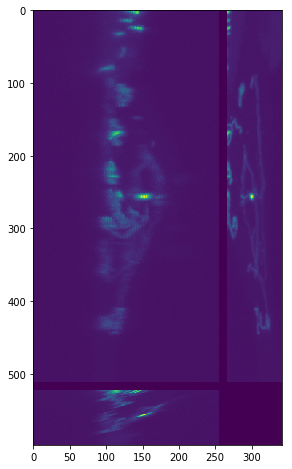

In [19]:
# inspect projections of raw volume
plot_all([get_projection_montage(vol_raw)])

In [20]:
skew = inv(deskew_mat(deskewfactor))
skew

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [-2.44671848, -0.        ,  1.        , -0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [21]:
unshift_raw = unshift_centre(vol_raw.shape)
combined_transform_skewed = unshift_raw @ skew @scale_psf @ shift
combined_transform_skewed 

array([[  0.63382967,   0.        ,   0.        ,  25.95723618],
       [  0.        ,   1.        ,   0.        , 224.        ],
       [ -1.55080278,   0.        ,   1.        , 122.46525282],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

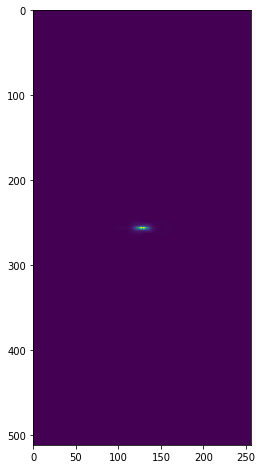

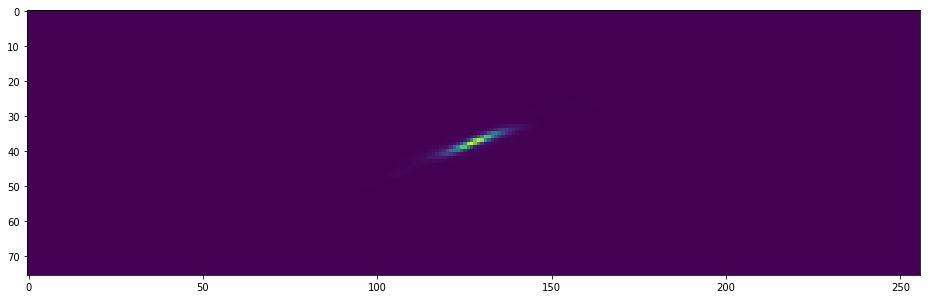

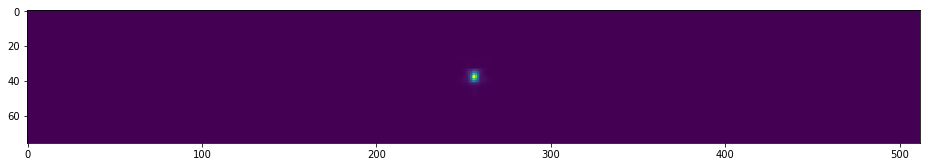

In [22]:
processed_psf_skewed = affine_transform(psf_bgcorr, inv(combined_transform_skewed), output_shape=vol_raw.shape)
# normalize intensity of PSF such that processed_psf.sum == 1
processed_psf_skewed /= processed_psf_skewed.sum()
plot_all(get_projections(processed_psf_skewed))

## Improving the PSF generation (TODO)

There are some refinements that could still be implemented:

* sub-pixel estimation of the centre location of the PSF, e.g. by fitting a Gaussian;
* averaging of multiple beads to improve signal to noise. 

Any hints about libraries that can already do this are welcome, I don't want to reinvent the wheel.

Note that in practice the PSF is spatially varying throughout the volume. 

# Perform Richardson-Lucy iterations

In [17]:
tfconfig= tf.ConfigProto(log_device_placement=True)

In [18]:
# Set number of iterations
niter = 10
# Intitialize
algo = tfd_restoration.RichardsonLucyDeconvolver(n_dims=3, start_mode='input').initialize()

deconvolve deskewed:

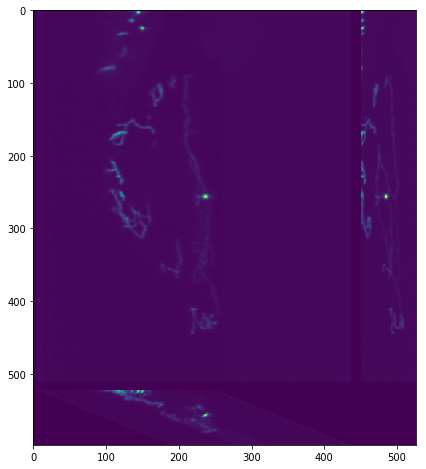

In [19]:
aq = fd_data.Acquisition(data=vol_deskewed, kernel=processed_psf)
restored = algo.run(aq, niter=niter, session_config=tfconfig).data
plot_all([get_projection_montage(restored)])

deconvolce skewed raw:

In [34]:
import gputools
%timeit gpdraw= gputools.deconv.deconv_rl(vol_raw, processed_psf_skewed, Niter=10)

13.8 s ± 488 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


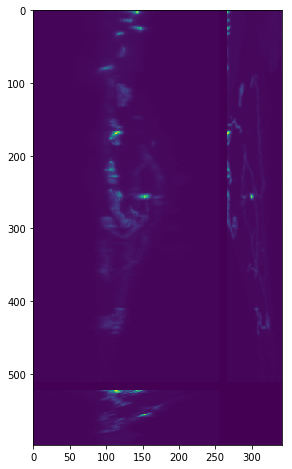

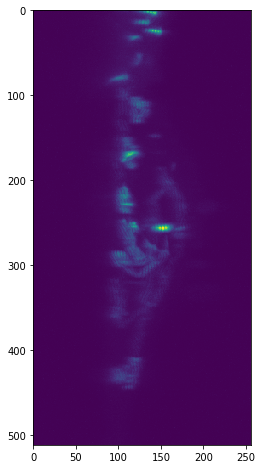

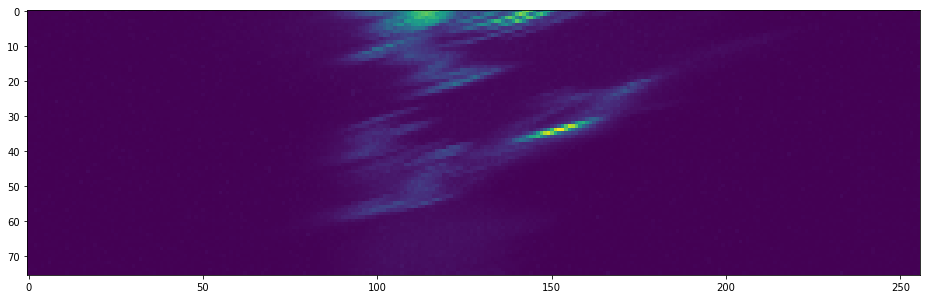

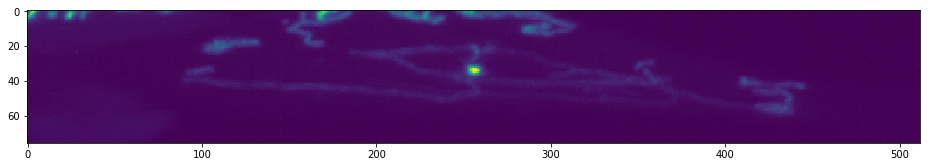

In [29]:
plot_all([get_projection_montage(gpdraw)])
plot_all(get_projections(vol_raw))

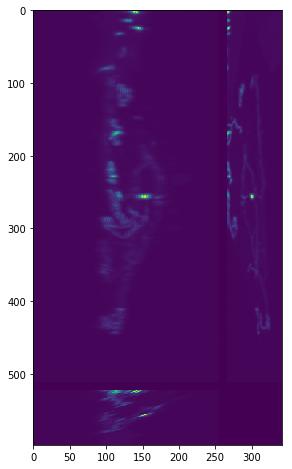

In [20]:
aq_raw = fd_data.Acquisition(data=vol_raw, kernel=processed_psf_skewed)
restored_raw = algo.run(aq_raw, niter=niter, session_config=tfconfig).data
plot_all([get_projection_montage(restored_raw)])

Deskew the deconvolved raw data:

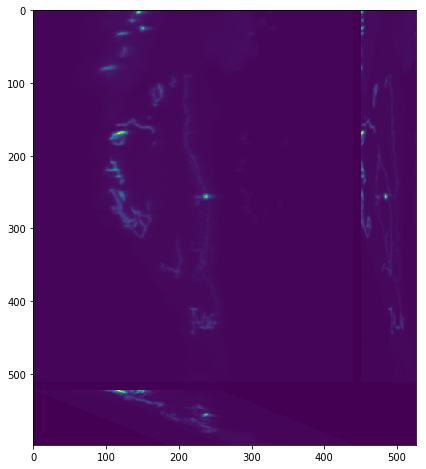

In [35]:
#deskewed_raw = affine_transform(restored_raw, skew, output_shape=vol_deskewed.shape)
deskewed_raw = affine_transform(gpdraw, skew, output_shape=(76, 512, 440))

plot_all([get_projection_montage(deskewed_raw)])

# Speed difference deconvolution raw/deskewed

Run the deconvolutions again and time them to see what the speedup is.
The difference in voxels between the raw data and the deskewed data is:

In [22]:
np.size(vol_deskewed)/np.size(vol_raw)

1.71875

Time the deconvolution on the deskewed:

In [23]:
%%timeit
restored = algo.run(aq, niter=niter).data

7.3 s ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Time the deconvolution on the raw:

In [24]:
%%timeit
restored_raw = algo.run(aq_raw, niter=niter).data

3.67 s ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Inspect the difference

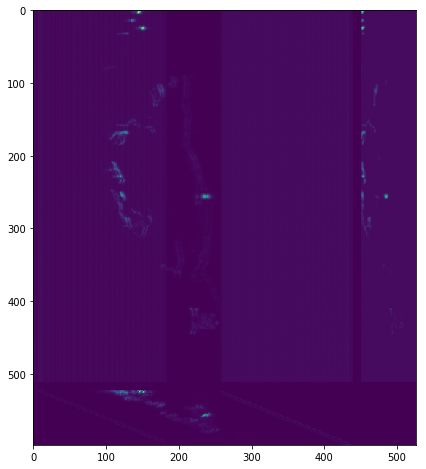

In [25]:
absdiff = np.abs(restored - deskewed_raw)
plot_all([get_projection_montage(absdiff)])

We observe that there is a horizontal displacement between the methods but otherwise the results are very similar.
I haven't gotten to the bottom of what exactly is causing the displacement but the centering of the PSF is a likely
explanation.

## Volume rendering

In addition to looking at projections, it is also possible to create a volume rendering in the Jupyter notebook. This requires installation of itkwidgets: https://github.com/InsightSoftwareConsortium/itk-jupyter-widgets

In [26]:
import itkwidgets

In [27]:
itkwidgets.view(deskewed_raw)

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…